In [1]:
!pip install pyDecision
!pip install jenkspy

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
  Using cached pyDecision-2.8.7-py3-none-any.whl (68 kB)
/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6

In [1]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pyDecision.algorithm import electre_tri_b
import jenkspy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load subset
df = pd.read_csv('/project/grouped_public.csv')
df.head(3)

,geometry,Public WiFi,number of bikes,Mean Inhabitants,Employment,Crime Degree,school_count,Flooding,hospitals_count,Income,...,Collision,Run over,Metro,Suburban Train,Metrobus,Trolleybus,RTP,Concessioned,e-bike,Total coverage of transport
0,"POLYGON ((471959.4893475254 2136241.824392597,...",4.0,0.0,1.194917,1.0,5.0,4.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,POLYGON ((482157.89084256295 2132902.396538757...,9.0,0.0,0.534557,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.666667,0.0,1.333333
2,POLYGON ((479437.4576426303 2141530.5071101547...,6.0,0.0,0.576814,1.0,2.0,4.0,1.5,4.0,0.0,...,0.0,2.0,0.0,0.0,0.000000,0.0,0.5,1.000000,0.0,1.500000


In [19]:
df.isna().sum()

Public WiFi                    0
number of bikes                0
Mean Inhabitants               0
Employment                     0
Crime Degree                   0
school_count                   0
Flooding                       0
hospitals_count                0
Income                         0
Deaths                         0
Injuries                       0
Collision                      0
Run over                       0
Metro                          0
Suburban Train                 0
Metrobus                       0
Trolleybus                     0
RTP                            0
Concessioned                   0
e-bike                         0
Total coverage of transport    0
dtype: int64

Drop geometry

In [3]:
df= df.drop(['geometry'], axis=1)

In [4]:
df.shape

(527, 21)

# Normalization

In [5]:
# Set numerical columns
df_columns_to_normalize = df.columns

n_scaler = MinMaxScaler()

# Create a copy of DataFrame
df_normalized = df.copy()

df_normalized[df_columns_to_normalize] = n_scaler.fit_transform(df_normalized[df_columns_to_normalize])

In [6]:
# Reverse the scale of the minimization criteria by subtracting from 1
minimization_criteria = ['Mean Inhabitants','Crime Degree','Deaths', 'Injuries', 'Run over',
                        'Flooding','Collision']


df_normalized[minimization_criteria] = 1 - df_normalized[minimization_criteria]

In [7]:
df_normalized.to_csv('data_normalized.csv', index=False)

# Parameter Selection

## Weight


In [23]:
df.columns

Index(['Public WiFi', 'number of bikes', 'Mean Inhabitants', 'Employment',
       'Crime Degree', 'school_count', 'Flooding', 'hospitals_count', 'Income',
       'Deaths', 'Injuries', 'Collision', 'Run over', 'Metro',
       'Suburban Train', 'Metrobus', 'Trolleybus', 'RTP', 'Concessioned',
       'e-bike', 'Total coverage of transport'],
      dtype='object')

In [8]:
# Create dictionary of importance scores given by experts

# Get the column names as a list
column_names = df_normalized.columns.tolist()
column_names

# Create the dictionary
importances= [8,5.5,4.5,7.5,10,4,10,5,7,10,10,10,10,6.5,4,10,2.5,2.5,6.5,4.5,9]
importance_dict = {column_names[i]: importances[i] for i in range(len(column_names))}

print(importance_dict)

{'Public WiFi': 8, 'number of bikes': 5.5, 'Mean Inhabitants': 4.5, 'Employment': 7.5, 'Crime Degree': 10, 'school_count': 4, 'Flooding': 10, 'hospitals_count': 5, 'Income': 7, 'Deaths': 10, 'Injuries': 10, 'Collision': 10, 'Run over': 10, 'Metro': 6.5, 'Suburban Train': 4, 'Metrobus': 10, 'Trolleybus': 2.5, 'RTP': 2.5, 'Concessioned': 6.5, 'e-bike': 4.5, 'Total coverage of transport': 9}


In [9]:


# get the min and max weights
min_weight = min(importance_dict.values())
max_weight = max(importance_dict.values())

# compute the range
weight_range = max_weight - min_weight

# scale the weights
scaled_weights = {key: 1 + 9 * ((value - min_weight) / weight_range) for key, value in importance_dict.items()}


In [10]:
# Factor by which to increase the weight of non-binary columns
increase_factor = 1.5

# Loop through columns in the DataFrame
for col in df.columns:
    # Check if the column is non-binary
    if df[col].nunique() > 2:
        # Increase the weight of the column in the weights dictionary
        scaled_weights[col] = scaled_weights[col] * increase_factor


In [11]:

W = list(scaled_weights.values())

W

[11.399999999999999,
 6.8999999999999995,
 5.1,
 10.5,
 15.0,
 4.199999999999999,
 15.0,
 6.0,
 9.6,
 15.0,
 15.0,
 15.0,
 15.0,
 8.7,
 4.199999999999999,
 15.0,
 1.5,
 1.5,
 8.7,
 5.1,
 13.200000000000001]

## Indifference Threshold

In [12]:
for column in df_normalized.columns:
    unique_values = df_normalized[column].unique()
    # Check if the unique values are only 0 and 1
    if set(unique_values) != {0, 1}:
        print(f"Unique values in column '{column}':")
        print(np.sort(unique_values))
        print()



Unique values in column 'Public WiFi':
[0.         0.00265252 0.00397878 0.00442087 0.00530504 0.0066313
 0.00795756 0.00928382 0.00972591 0.00994695 0.01061008 0.0132626
 0.01458886 0.01591512 0.01856764 0.02122016 0.02387268 0.0265252
 0.02785146 0.02917772 0.03183024 0.0530504  0.09018568 0.10344828
 0.13793103 1.        ]

Unique values in column 'number of bikes':
[0.         0.33333333 0.41666667 0.45833333 0.5        0.54166667
 0.58333333 0.61111111 0.625      0.66666667 0.70833333 0.75
 0.79166667 0.80555556 0.8125     0.83333333 0.875      0.88888889
 0.91666667 0.95833333 1.        ]

Unique values in column 'Mean Inhabitants':
[0.         0.09407151 0.22864335 0.22900072 0.2584067  0.27602052
 0.28791828 0.30189622 0.30666785 0.30825839 0.31171382 0.33731518
 0.34553872 0.35667318 0.37273414 0.37915286 0.38495458 0.3995047
 0.40512391 0.42622759 0.4344498  0.43608451 0.44246921 0.45473864
 0.45673775 0.48171377 0.50046373 0.50384095 0.52680571 0.53264187
 0.53526767 0.54074

In [13]:
# Create a dictionary where each key is a column name and each value is 0
indifference_dict = {column: 0.01 for column in column_names}

# Manually adjust the weights for the specific columns
indifference_dict['Public WiFi'] = 0.1
indifference_dict['number of bikes'] = 0.3
indifference_dict['Mean Inhabitants'] = 0.1
indifference_dict['Employment'] = 0.1
indifference_dict['school_count'] = 0.2
indifference_dict['Metro'] = 0.2
indifference_dict['Metrobus'] = 0.2
indifference_dict['Trolleybus'] = 0.2
indifference_dict['RTP'] = 0.2
indifference_dict['Concessioned'] = 0.2
indifference_dict['e-bike'] = 0.2

print(indifference_dict)


{'Public WiFi': 0.1, 'number of bikes': 0.3, 'Mean Inhabitants': 0.1, 'Employment': 0.1, 'Crime Degree': 0.01, 'school_count': 0.2, 'Flooding': 0.01, 'hospitals_count': 0.01, 'Income': 0.01, 'Deaths': 0.01, 'Injuries': 0.01, 'Collision': 0.01, 'Run over': 0.01, 'Metro': 0.2, 'Suburban Train': 0.01, 'Metrobus': 0.2, 'Trolleybus': 0.2, 'RTP': 0.2, 'Concessioned': 0.2, 'e-bike': 0.2, 'Total coverage of transport': 0.01}


In [14]:
Q = list(indifference_dict.values())

 ## Preference Threshold

In [15]:
# Create a dictionary where each key is a column name and each value is 0
preference_dict = {column: 0.99 for column in column_names}

# Manually adjust the weights for the specific columns
preference_dict['Total coverage of transport'] = 0.3
preference_dict['Crime Degree'] = 0.01
preference_dict['Flooding'] = 0.05
preference_dict['Deaths'] = 0.05
preference_dict['Injuries'] = 0.05
preference_dict['Collision'] = 0.05
preference_dict['Run over'] = 0.05



print(preference_dict)

{'Public WiFi': 0.99, 'number of bikes': 0.99, 'Mean Inhabitants': 0.99, 'Employment': 0.99, 'Crime Degree': 0.01, 'school_count': 0.99, 'Flooding': 0.05, 'hospitals_count': 0.99, 'Income': 0.99, 'Deaths': 0.05, 'Injuries': 0.05, 'Collision': 0.05, 'Run over': 0.05, 'Metro': 0.99, 'Suburban Train': 0.99, 'Metrobus': 0.99, 'Trolleybus': 0.99, 'RTP': 0.99, 'Concessioned': 0.99, 'e-bike': 0.99, 'Total coverage of transport': 0.3}


In [16]:
P = list(preference_dict.values())

## Veto Threshold

In [17]:
# Create a dictionary where each key is a column name and each value is 0
veto_dict = {column: 0.99 for column in column_names}

veto_dict['Total coverage of transport'] = 0.3
veto_dict['Crime Degree'] = 0.1
veto_dict['Flooding'] = 0.1
veto_dict['Deaths'] = 0.1
veto_dict['Injuries'] = 0.1
veto_dict['Collision'] = 0.1
veto_dict['Run over'] = 0.1


print(veto_dict)

{'Public WiFi': 0.99, 'number of bikes': 0.99, 'Mean Inhabitants': 0.99, 'Employment': 0.99, 'Crime Degree': 0.1, 'school_count': 0.99, 'Flooding': 0.1, 'hospitals_count': 0.99, 'Income': 0.99, 'Deaths': 0.1, 'Injuries': 0.1, 'Collision': 0.1, 'Run over': 0.1, 'Metro': 0.99, 'Suburban Train': 0.99, 'Metrobus': 0.99, 'Trolleybus': 0.99, 'RTP': 0.99, 'Concessioned': 0.99, 'e-bike': 0.99, 'Total coverage of transport': 0.3}


In [18]:
V = list(veto_dict.values())

## Boundaries by implementing Jenks Breaks

In [19]:
# Initialize an empty dictionary to store the breaks for each column
breaks_dict = {}

# Loop through each column in the DataFrame
for column in df_normalized.columns:
    if df_normalized[column].nunique() > 2:  # If the column is non-binary
        # Apply jenks_breaks to the column
        breaks = jenkspy.jenks_breaks(df_normalized[column], n_classes=2)
    else:  # If the column is binary
        # Manually set the breaks
        breaks = [0, 1]
    # Save the breaks in the dictionary with the column name as the key
    breaks_dict[column] = breaks



In [20]:
print(breaks_dict)

{'Public WiFi': [0.0, 0.13793103448275862, 1.0], 'number of bikes': [0.0, 0.6666666666666666, 1.0], 'Mean Inhabitants': [0.0, 0.6106611678322194, 1.0], 'Employment': [0.0, 0.5, 1.0], 'Crime Degree': [0.0, 0.75, 1.0], 'school_count': [0.0, 0.2383073496659243, 1.0], 'Flooding': [0.0, 0.4375, 1.0], 'hospitals_count': [0.0, 0.19970359392367543, 1.0], 'Income': [0.0, 0.25, 1.0], 'Deaths': [0.0, 0.5, 1.0], 'Injuries': [0.0, 0.8333333333333334, 1.0], 'Collision': [0.0, 0.6666666666666667, 1.0], 'Run over': [0.0, 0.6666666666666667, 1.0], 'Metro': [0.0, 0.5, 1.0], 'Suburban Train': [0.0, 0.0, 1.0], 'Metrobus': [0.0, 0.4285714285714285, 1.0], 'Trolleybus': [0.0, 0.3333333333333333, 1.0], 'RTP': [0.0, 0.4, 1.0], 'Concessioned': [0.0, 0.75, 1.0], 'e-bike': [0.0, 0.6666666666666666, 1.0], 'Total coverage of transport': [0.0, 0.611111111111111, 1.0]}


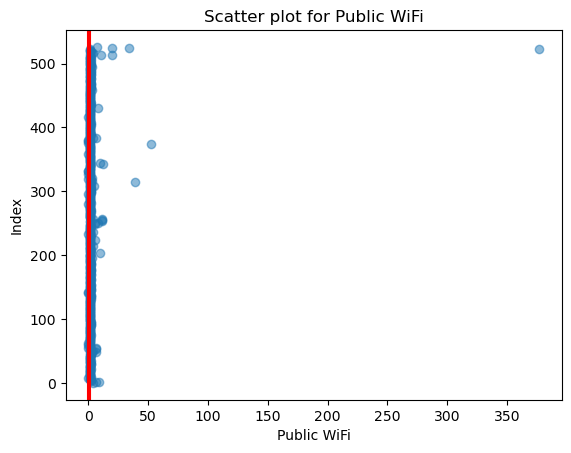

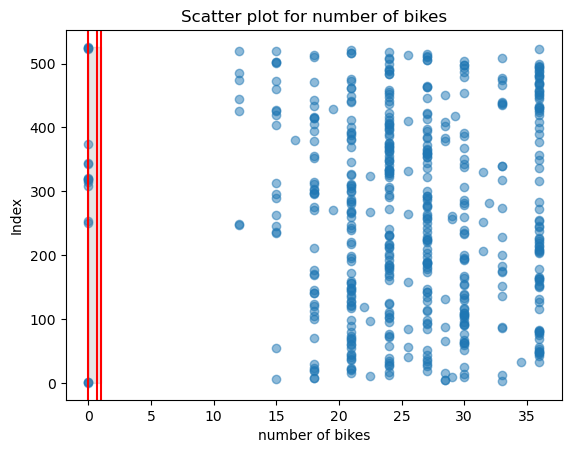

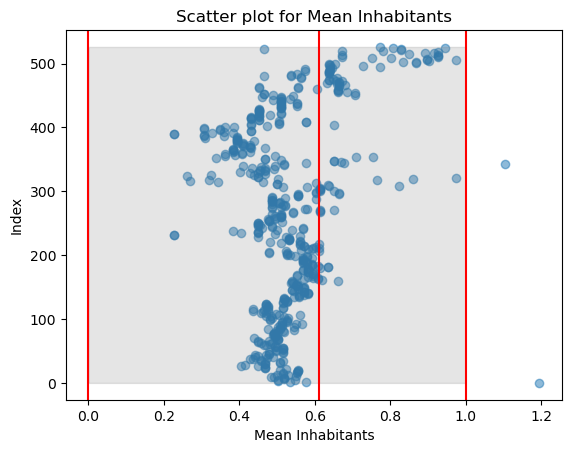

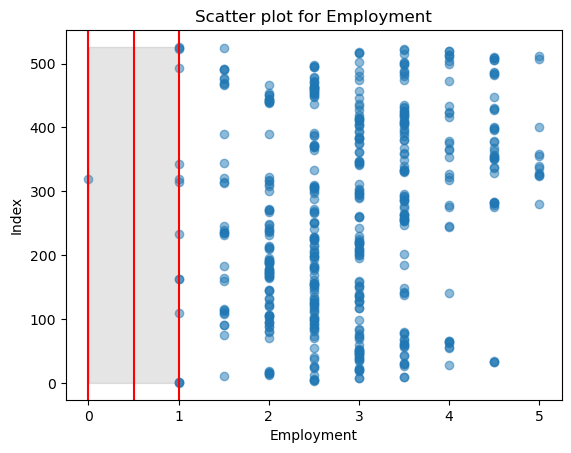

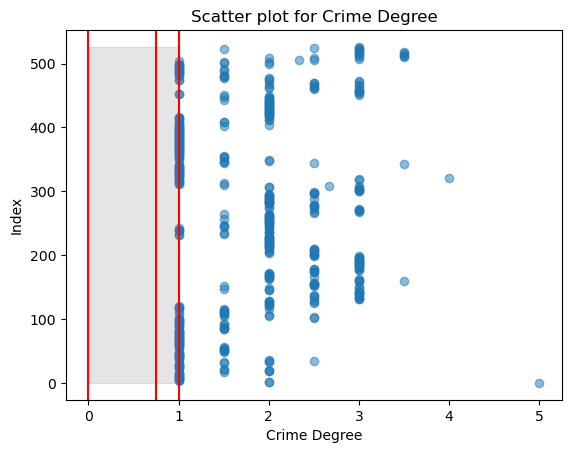

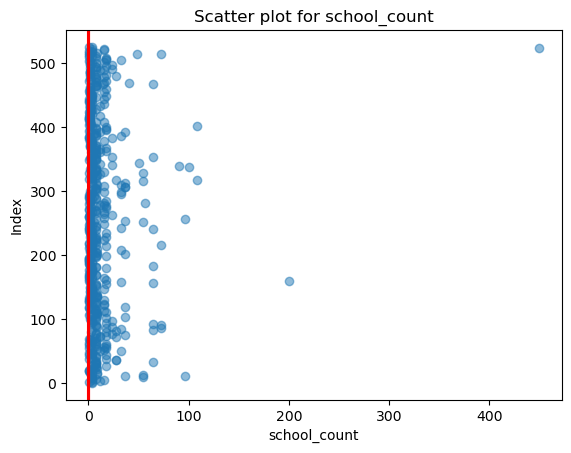

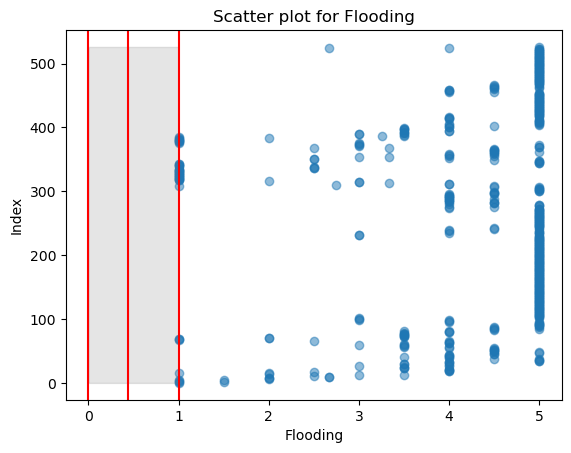

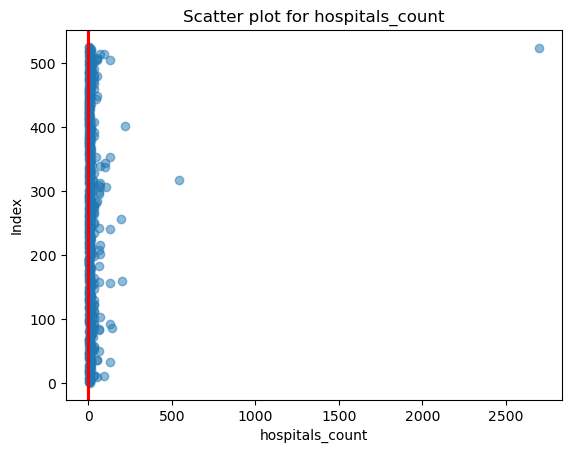

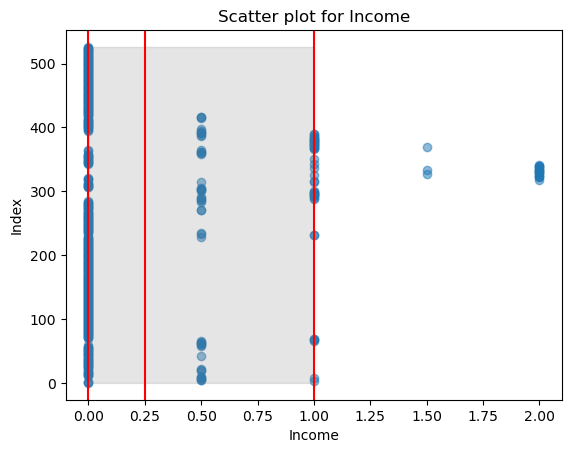

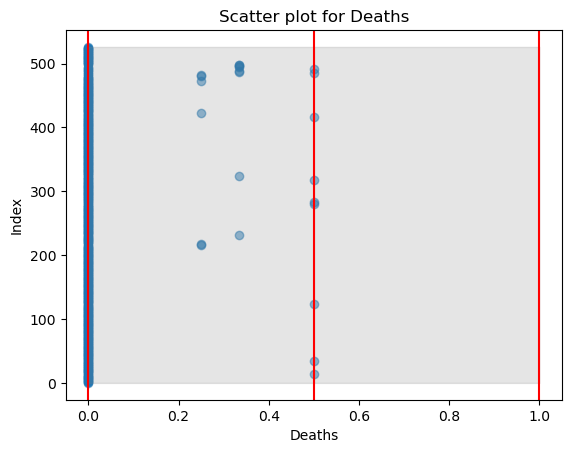

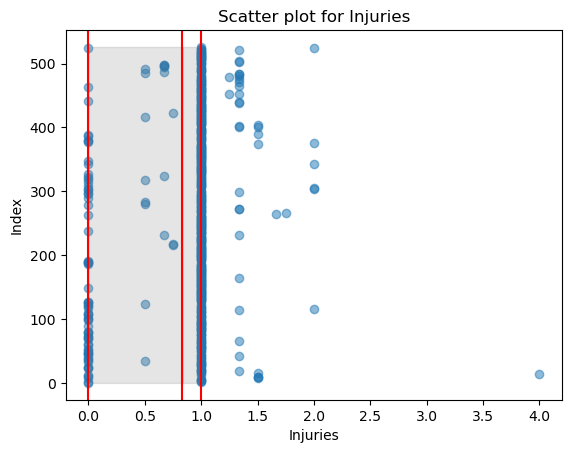

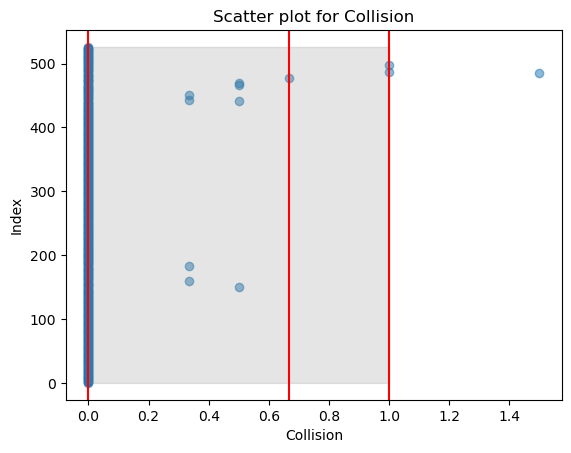

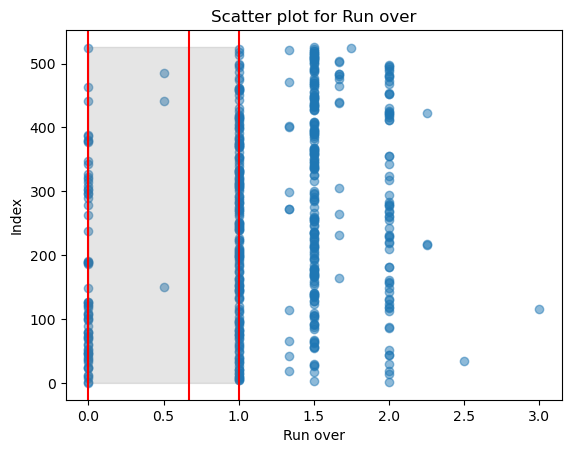

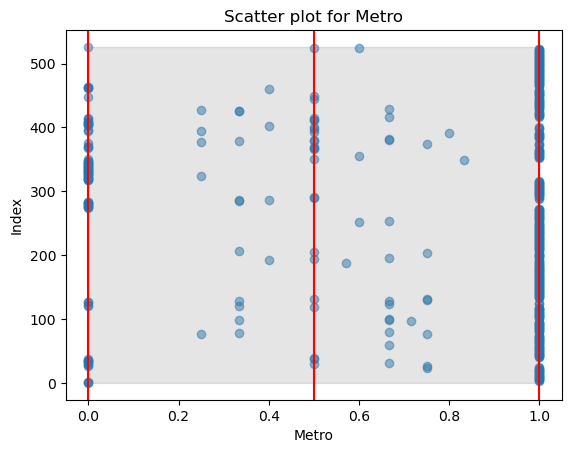

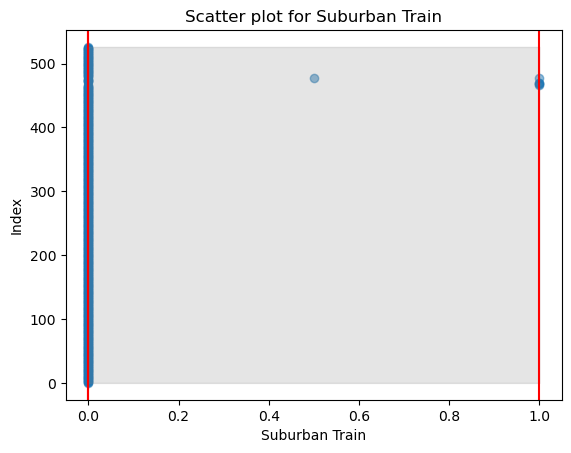

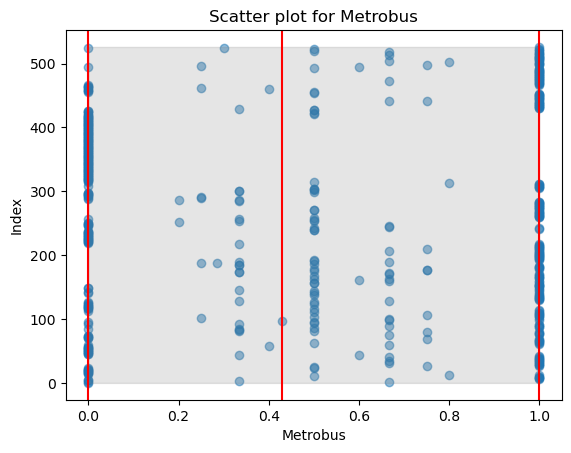

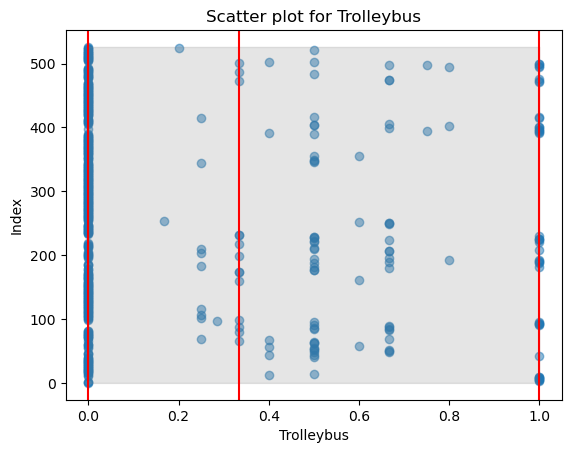

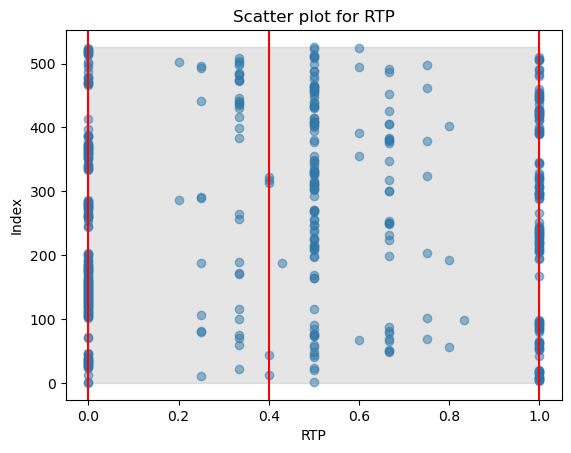

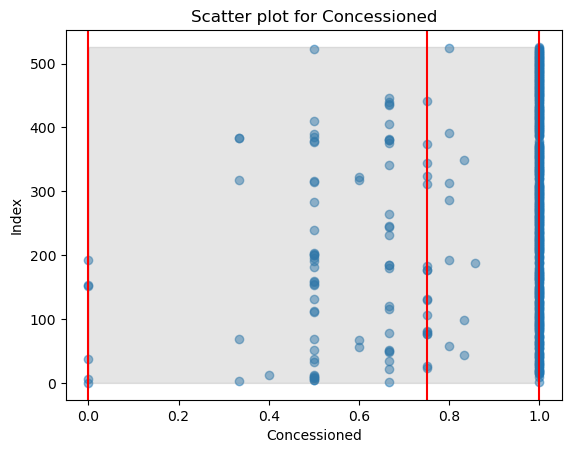

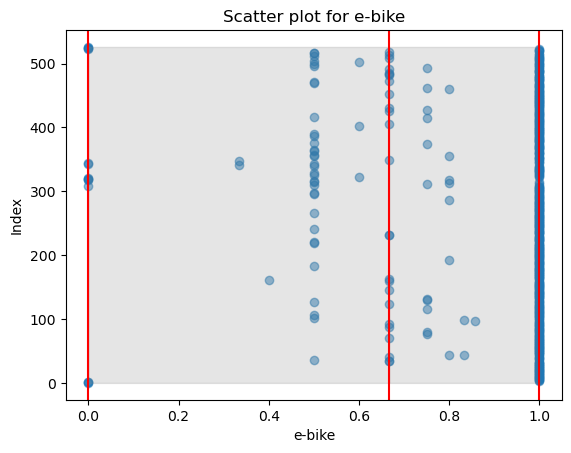

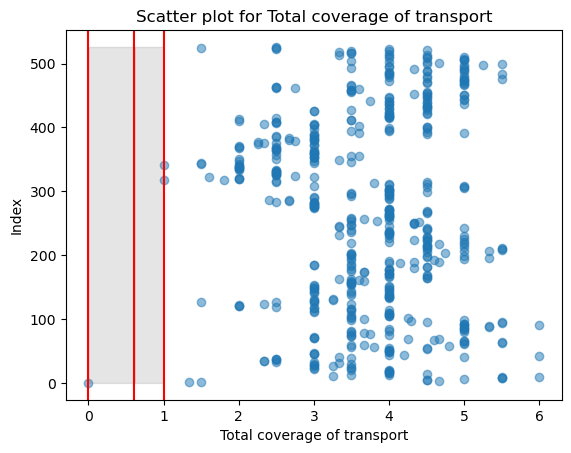

In [39]:
import numpy as np
import matplotlib.pyplot as plt

for column, breaks in breaks_dict.items():
    plt.scatter(df[column], df.index, alpha=0.5)

    sorted_breaks = sorted(breaks)
    for i in range(len(sorted_breaks) - 1):
        plt.fill_betweenx(df.index, sorted_breaks[i], sorted_breaks[i+1], color='gray', alpha=0.2)

    # Add vertical lines for the break points
    for break_point in breaks:
        plt.axvline(x=break_point, color='r')
    
    # Add title and labels
    plt.title(f'Scatter plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Index')
    
    plt.show()



In [21]:
B1 = []
B2 = []

for key in breaks_dict:
    if len(breaks_dict[key]) == 2:  # Binary case
        B1.append(breaks_dict[key][0])
        B2.append(breaks_dict[key][1])
    else:  # Non-binary case
        # You can change these indices based on where you want the thresholds to be
        B1.append(breaks_dict[key][1]) 
        B2.append(breaks_dict[key][2])

print(B1)
print(B2)



[0.13793103448275862, 0.6666666666666666, 0.6106611678322194, 0.5, 0.75, 0.2383073496659243, 0.4375, 0.19970359392367543, 0.25, 0.5, 0.8333333333333334, 0.6666666666666667, 0.6666666666666667, 0.5, 0.0, 0.4285714285714285, 0.3333333333333333, 0.4, 0.75, 0.6666666666666666, 0.611111111111111]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [22]:
B = [B1, B2]

# ELECTRE-TRI

In [39]:
df_normalized = pd.read_csv('/project/data_normalized.csv')

In [23]:
# Convert to array format

arr = df_normalized.values
arr
df_normalized

,Public WiFi,number of bikes,Mean Inhabitants,Employment,Crime Degree,school_count,Flooding,hospitals_count,Income,Deaths,...,Collision,Run over,Metro,Suburban Train,Metrobus,Trolleybus,RTP,Concessioned,e-bike,Total coverage of transport
0,0.010610,0.000000,0.000000,0.2,0.000,0.006682,1.000000,0.002594,0.00,1.0,...,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,0.023873,0.000000,0.681173,0.2,0.750,0.000000,1.000000,0.000000,0.00,1.0,...,1.0,1.000000,0.0,0.0,0.666667,0.0,0.0,0.666667,0.0,0.222222
2,0.015915,0.000000,0.637584,0.2,0.750,0.006682,0.875000,0.001112,0.00,1.0,...,1.0,0.333333,0.0,0.0,0.000000,0.0,0.5,1.000000,0.0,0.250000
3,0.005305,0.916667,0.715733,0.5,1.000,0.024499,1.000000,0.004076,0.50,1.0,...,1.0,0.500000,1.0,0.0,0.333333,1.0,1.0,0.333333,1.0,0.777778
4,0.002653,0.791667,0.667982,0.5,1.000,0.033408,0.875000,0.005558,0.25,1.0,...,1.0,0.666667,1.0,0.0,0.000000,1.0,1.0,0.500000,1.0,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,0.003979,1.000000,0.379153,0.7,0.500,0.033408,0.000000,0.005558,0.00,1.0,...,1.0,0.500000,1.0,0.0,1.000000,0.0,0.0,1.000000,1.0,0.666667
523,1.000000,0.000000,0.753552,0.2,0.875,0.006682,0.000000,0.002594,0.00,1.0,...,1.0,0.666667,1.0,0.0,0.500000,0.0,0.5,0.500000,0.0,0.416667
524,0.090186,0.000000,0.399505,0.3,0.625,1.000000,0.583333,1.000000,0.00,1.0,...,1.0,0.416667,0.6,0.0,0.300000,0.2,0.6,0.800000,0.0,0.416667
525,0.053050,0.000000,0.258407,0.2,0.500,0.000000,0.250000,0.000000,0.00,1.0,...,1.0,1.000000,0.5,0.0,0.000000,0.0,0.0,1.000000,0.0,0.250000


In [41]:
df_normalized.describe()

,Storefront,Visible Sign of Business,Business WiFi,Business tables,Business Plugs,Business Internal CCTV,External CCTV,Number of female employees,Accepts credit card,Incline,...,Deaths,Injuries,Run over,Metro,Metrobus,Trolleybus,RTP,Concessioned,e-bike,Total coverage of transport
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.0,214.000000,214.000000,214.000000,214.0,214.000000,214.000000
mean,0.518692,0.518692,0.499429,0.514019,0.518692,0.504673,0.516355,0.128531,0.058411,0.678679,...,0.982866,0.891589,0.667835,1.0,0.965732,0.457165,0.300623,1.0,0.834891,0.423364
std,0.500822,0.500822,0.493014,0.500975,0.500822,0.501150,0.495604,0.184681,0.231294,0.285279,...,0.112899,0.126102,0.361891,0.0,0.143069,0.454053,0.421104,0.0,0.300838,0.257135
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,1.000000,0.800000,0.500000,1.0,1.000000,0.000000,0.000000,1.0,0.666667,0.200000
50%,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,0.750000,0.000000,0.000000,0.500000,...,1.000000,0.933333,0.750000,1.0,1.000000,0.500000,0.000000,1.0,1.000000,0.400000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.266667,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.500000,1.0,1.000000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [31]:
# With no parameters:

W_n= [0] * 82
W_n[0]=0.1
W_n[1]=0.2
W_n[2]=0.4
Q_n=[0] * 82
P_n=[0.5] * 82
V_n=[1] * 82

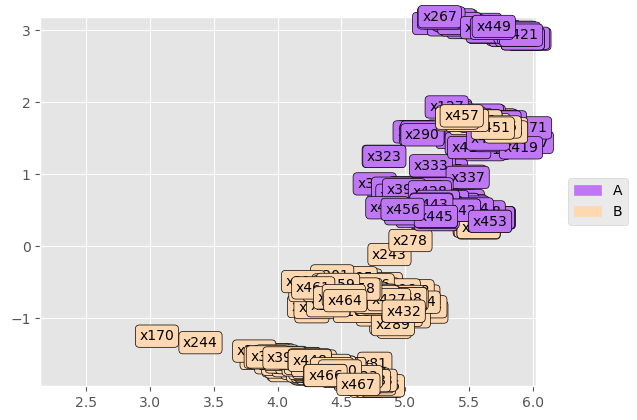

In [32]:
classification_n = electre_tri_b(arr, W_n , Q_n , P_n , V_n , B , verbose = False, rule = 'oc', graph = True)



In [27]:
from collections import Counter

# Classification 
counter = Counter(classification)
for cls, count in counter.items():
    print(f'Class: {cls}, Number of Records: {count}')

Class: 2, Number of Records: 463
Class: 1, Number of Records: 64


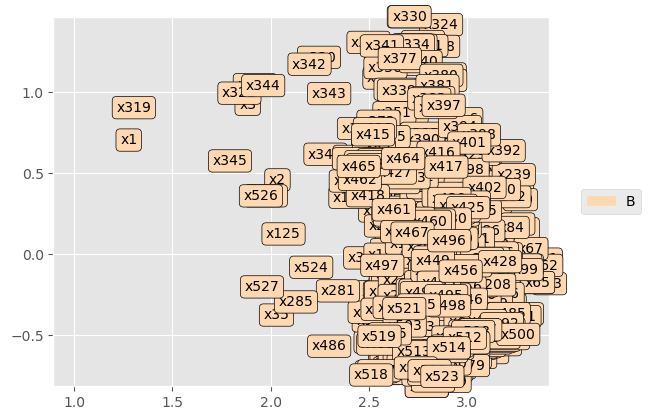

In [29]:
classification = electre_tri_b(arr, W , Q , P , V , B , cut_level = 0.50, verbose = False,
                               rule = 'oc', graph = True)


In [48]:
def evaluate_result(classification):
    counter = Counter(classification)
    classes = list(counter.keys())  # This will give you a list of class labels
    return classes



In [54]:
best_thresholds = {"Q": 0, "P": 0, "V": 0}
best_result = []

thresholds = np.arange(0, 1.01, 0.05) # This generates array [0, 0.05, 0.1, ..., 1]

for q_threshold in thresholds:
    for p_threshold in thresholds:
        for v_threshold in thresholds:
            Q = [q_threshold]*len(W)
            P = [p_threshold]*len(W)
            V = [v_threshold]*len(W)
            classification = electre_tri_b(arr, W , Q , P , V , B , cut_level = 0.5, verbose = False, rule = 'oc')
            result = evaluate_result(classification)
            
            if len(result) > len(best_result):  # If the new result has more classes
                best_result = result
                best_thresholds = {"Q": q_threshold, "P": p_threshold, "V": v_threshold}

print('Best thresholds:', best_thresholds)
print('Best result (class labels):', best_result)




Best thresholds: {'Q': 0.0, 'P': 0.0, 'V': 0.05}
Best result (class labels): [1, 0]


In [51]:
import numpy as np


best_threshold = None
best_result = None
best_evaluation = float('-inf')  # or some large negative value

for p in np.linspace(0, 1, num=101):  # try P thresholds from 0 to 1, inclusive
    P = [p] * len(Q)
    result = electre_tri_b(arr, W, Q, P, V, B, cut_level=0.5, verbose=False, rule='oc')
    
    evaluation = evaluate_result(result)  # function to evaluate the result
    
    if evaluation > best_evaluation:
        best_evaluation = evaluation
        best_threshold = p
        best_result = result


TypeError: '>' not supported between instances of 'list' and 'float'

In [50]:
print('Best threshold:', best_threshold)
print('Best result:', best_result)

Best threshold: None
Best result: None


# Feature Engineering for removing Binary Variables

In [8]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
binary_columns

['Storefront',
 'Visible Sign of Business',
 'Business tables',
 'Business Plugs',
 'Business Internal CCTV',
 'Strip services',
 'Material',
 'Commerciality',
 'Incivility',
 'Obstacles',
 'Physical aspects in poor condition',
 'Poor infrastructure',
 'Positive elements',
 'Broken drain-cover',
 'Drug addicts',
 'Federal Judiciary',
 'Panic button',
 'Vandalism',
 'graffiti',
 'homelessness',
 'inclined ramp',
 'indication of security',
 'police presence',
 'risky pavement',
 'risky road',
 'tourist map',
 'trash',
 'vehicle abandoned',
 'Ice Cream Shop']

In [42]:
dfx= df.copy()

In [10]:
d1 = df[['Storefront', 'Visible Sign of Business', 'Business tables', 
           'Business Plugs', 'Business Internal CCTV', 'Strip services', 
           'Material', 'Commerciality', 'Incivility', 'Obstacles', 
           'Physical aspects in poor condition', 'Poor infrastructure', 
           'Positive elements', 'Broken drain-cover', 'Drug addicts', 
           'Federal Judiciary', 'Panic button', 'Vandalism', 'graffiti', 
           'homelessness', 'inclined ramp', 'indication of security', 
           'police presence', 'risky pavement', 'risky road', 
           'tourist map', 'trash', 'vehicle abandoned']]


Security Score: Combination of 'Federal Judiciary', 'Panic button', 'indication of security', 'police presence'. Sum these up to create a score which indicates the overall level of security measures in a given area.

In [12]:
d1['Security Index'] = d1[['Federal Judiciary', 'Panic button', 'indication of security']].sum(axis=1) - df['police presence']


/tmp/ipykernel_152/1550993996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['Security Index'] = d1[['Federal Judiciary', 'Panic button', 'indication of security']].sum(axis=1) - df['police presence']


Amenity Score: This can be a combination of 'Storefront', 'Visible Sign of Business', 'Business tables', 'Business Plugs', 'Business Internal CCTV', 'Ice Cream Shop'. This score indicates the general level of amenity and commercial activity in an area.

In [13]:
d1['Amenity Index'] = d1[['Storefront', 'Visible Sign of Business', 
                          'Business tables', 'Business Plugs', 
                        'Business Internal CCTV']].sum(axis=1)




/tmp/ipykernel_152/1745561843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['Amenity Index'] = d1[['Storefront', 'Visible Sign of Business',


In [29]:
d1['Incivility Index'] = d1[['Incivility', 'Drug addicts', 'Vandalism', 'graffiti', 'homelessness']].sum(axis=1)



In [28]:
d1['Infrastructure Index'] = d1[['Obstacles', 'Physical aspects in poor condition', 
                                 'Poor infrastructure', 'Broken drain-cover', 
                                  'risky pavement', 'risky road','trash']].sum(axis=1)
- d1[['Strip services', 'Material',  
      'inclined ramp']].sum(axis=1)


0     -0.0
1     -0.0
2     -0.0
3     -0.0
4     -0.0
      ... 
209   -0.0
210   -0.0
211   -2.0
212   -2.0
213   -2.0
Length: 214, dtype: float64

In [27]:

d1['Tourism Index'] = d1[['tourist map', 'Commerciality']].sum(axis=1)

In [43]:
dfx.columns

Index(['geometry', 'Storefront', 'Visible Sign of Business', 'Business WiFi',
       'Business tables', 'Business Plugs', 'Business Internal CCTV',
       'External CCTV', 'Number of female employees', 'Accepts credit card',
       'Incline', 'Width', 'Ramp conditions', 'Ramp // Crosswalk',
       'Ramp obstacles', 'Crosswalk width', 'Vertical signs',
       'Crossing length', 'Access to people with disabilities',
       'Pedestrian strip width', 'Strip services', 'Material',
       'Status of maintenance', 'Continuity', 'Temporary obstacles', 'Benches',
       'Trees', 'Planters', 'Commerciality', 'Percentage of parking accesses',
       'Broken public property', 'Incivility', 'Obstacles',
       'Physical aspects in poor condition', 'Poor infrastructure',
       'Positive elements', 'Broken drain-cover', 'Drug addicts',
       'Federal Judiciary', 'Panic button', 'Vandalism', 'graffiti',
       'homelessness', 'inclined ramp', 'indication of security',
       'mobile vendors', 'polic

In [44]:
dfx.drop(['geometry','Storefront', 'Visible Sign of Business', 'Business tables', 
           'Business Plugs', 'Business Internal CCTV', 'Strip services', 
           'Material', 'Commerciality', 'Incivility', 'Obstacles', 
           'Physical aspects in poor condition', 'Poor infrastructure', 
           'Positive elements', 'Broken drain-cover', 'Drug addicts', 
           'Federal Judiciary', 'Panic button', 'Vandalism', 'graffiti', 
           'homelessness', 'inclined ramp', 'indication of security', 
           'police presence', 'risky pavement', 'risky road', 
           'tourist map', 'trash', 'vehicle abandoned','Ice Cream Shop'],axis=1, inplace=True)

In [45]:
dfx = pd.concat([dfx, d1[['Security Index', 'Amenity Index',
                          'Incivility Index', 'Infrastructure Index', 'Tourism Index']]], axis=1)


In [46]:
binary_columns_dfx = [col for col in dfx.columns if dfx[col].nunique() == 2]
binary_columns_dfx

[]

In [47]:
non_binary_columns_dfx = [col for col in dfx.columns if dfx[col].nunique() > 2]
non_binary_columns_dfx

['Business WiFi',
 'External CCTV',
 'Number of female employees',
 'Accepts credit card',
 'Incline',
 'Width',
 'Ramp conditions',
 'Ramp // Crosswalk',
 'Ramp obstacles',
 'Crosswalk width',
 'Vertical signs',
 'Crossing length',
 'Access to people with disabilities',
 'Pedestrian strip width',
 'Status of maintenance',
 'Continuity',
 'Temporary obstacles',
 'Benches',
 'Trees',
 'Planters',
 'Percentage of parking accesses',
 'Broken public property',
 'mobile vendors',
 'risky building',
 'Coffee Shop',
 'Food joint',
 'Lighting Stores',
 'Restaurant',
 'Open-Weekdays',
 'Open-Weekends',
 'crosswalk',
 'Street Lighting',
 'Public WiFi',
 'number of bikes',
 'Mean Inhabitants',
 'Employment',
 'Crime Degree',
 'Deaths',
 'Injuries',
 'Run over',
 'Metrobus',
 'Trolleybus',
 'RTP',
 'e-bike',
 'Total coverage of transport',
 'Security Index',
 'Amenity Index',
 'Incivility Index',
 'Infrastructure Index',
 'Tourism Index']

In [48]:
dfx[non_binary_columns_dfx] = n_scaler.fit_transform(dfx[non_binary_columns_dfx])

In [38]:
dfx = pd.DataFrame(dfx)


In [52]:
# Reverse the scale of the minimization criteria by subtracting from 1
minimization_criteria_dfx = ['Incline','Ramp obstacles','Broken public property', 
                         'risky building','Mean Inhabitants','Crime Degree',
                             'Deaths', 'Injuries', 'Run over',
                        'Incivility Index', 'Infrastructure Index']

dfx[minimization_criteria_dfx] = 1 - dfx[minimization_criteria_dfx]

In [55]:
dfx.shape


(214, 52)

In [187]:
dfx.drop(['Business WiFi','Accepts credit card','Width','Ramp conditions','Ramp // Crosswalk',
         'Crossing length','Pedestrian strip width','Status of maintenance','Temporary obstacles',
         'Planters','Percentage of parking accesses','mobile vendors','Restaurant','Open-Weekdays',
         'Street Lighting','Public WiFi','Amenity Index','Tourism Index','External CCTV'],axis=1,inplace=True)



'External CCTV': [0.0, 0.0, 1.0], 'Accepts credit card': [0.0, 0.0, 1.0], 'Width': [0.0, 0.0, 1.0], 'Ramp conditions': [0.0, 0.0, 1.0], 'Ramp // Crosswalk': [0.0, 0.0, 1.0], 'Crossing length': [0.0, 0.0, 1.0], 'Pedestrian strip width': [0.0, 0.0, 1.0], 'Status of maintenance': [0.0, 0.0, 1.0], 'Temporary obstacles': [0.0, 0.0, 1.0], 'Planters': [0.0, 0.0, 1.0], 'Percentage of parking accesses': [0.0, 0.0, 1.0], 'mobile vendors': [0.0, 0.0, 1.0], 'Restaurant': [0.0, 0.0, 1.0], 'Open-Weekdays': [0.0, 0.0, 1.0], 'Street Lighting': [0.0, 0.0, 1.0], 'Public WiFi': [0.0, 0.0, 1.0], 'Amenity Index': [0.0, 0.0, 1.0], 'Tourism Index': [0.0, 0.0, 1.0]}

In [244]:
dfx.to_csv('dfx.csv', index=False)

# Weight

{'Storefront': 10, 'Visible Sign of Business': 7.5, 'Business WiFi': 5, 'Business tables': 6, 'Business Plugs': 9, 'Business Internal CCTV': 7.75, 'External CCTV': 8.5, 'Number of female employees': 10, 'Accepts credit card': 10, 'Incline': 8, 'Width': 4, 'Ramp conditions': 6.5, 'Ramp // Crosswalk': 8.5, 'Ramp obstacles': 9.5, 'Crosswalk width': 9, 'Vertical signs': 8.5, 'Crossing length': 6.5, 'Access to people with disabilities': 10, 'Pedestrian strip width': 8, 'Strip services': 9, 'Material': 5, 'Status of maintenance': 8, 'Continuity': 7.75, 'Temporary obstacles': 6, 'Benches': 5, 'Trees': 8, 'Planters': 3, 'Commerciality': 9, 'Percentage of parking accesses': 10, 'Broken public property': 9, 'Incivility': 9, 'Obstacles': 8, 'Physical aspects in poor condition': 9, 'Poor infrastructure': 9, 'Positive elements': 9, 'Broken drain-cover': 10, 'Drug addicts': 10, 'Federal Judiciary': 5, 'Panic button': 3.75, 'Vandalism': 10, 'graffiti': 4, 'homelessness': 8.25, 'inclined ramp': 7.5, 'indication of security': 5, 'mobile vendors': 5.5, 'police presence': 2.5, 'risky building': 10, 'risky pavement': 10, 'risky road': 9, 'tourist map': 9, 'trash': 10, 'vehicle abandoned': 3.5, 'Coffee Shop': 10, 'Food joint': 10, 'Ice Cream Shop': 7.5, 'Lighting Stores': 1.5, 'Restaurant': 10, 'Open-Weekdays': 9.5, 'Open-Weekends': 10, 'crosswalk': 5, 'Street Lighting': 10, 'Public WiFi': 8, 'number of bikes': 5.5, 'Mean Inhabitants': 4.5, 'Employment': 7.5, 'Crime Degree': 10, 'Deaths': 10, 'Injuries': 10, 'Run over': 10, 'Metro': 6.5, 'Metrobus': 10, 'Trolleybus': 2.5, 'RTP': 2.5, 'Concessioned': 6.5, 'e-bike': 4.5, 'Total coverage of transport': 9}

In [68]:
# Get the column names as a list
column_names = dfx.columns.tolist()
column_names

['Business WiFi',
 'External CCTV',
 'Number of female employees',
 'Accepts credit card',
 'Incline',
 'Width',
 'Ramp conditions',
 'Ramp // Crosswalk',
 'Ramp obstacles',
 'Crosswalk width',
 'Vertical signs',
 'Crossing length',
 'Access to people with disabilities',
 'Pedestrian strip width',
 'Status of maintenance',
 'Continuity',
 'Temporary obstacles',
 'Benches',
 'Trees',
 'Planters',
 'Percentage of parking accesses',
 'Broken public property',
 'mobile vendors',
 'risky building',
 'Coffee Shop',
 'Food joint',
 'Lighting Stores',
 'Restaurant',
 'Open-Weekdays',
 'Open-Weekends',
 'crosswalk',
 'Street Lighting',
 'Public WiFi',
 'number of bikes',
 'Mean Inhabitants',
 'Employment',
 'Crime Degree',
 'Deaths',
 'Injuries',
 'Run over',
 'Metro',
 'Metrobus',
 'Trolleybus',
 'RTP',
 'Concessioned',
 'e-bike',
 'Total coverage of transport',
 'Security Index',
 'Amenity Index',
 'Incivility Index',
 'Infrastructure Index',
 'Tourism Index']

In [67]:
# Define the columns for security index
security_index_cols = ['Federal Judiciary', 'Panic button', 'indication of security', 'police presence']

# Get the scores of the defined columns
security_scores = [importance_dict[col] for col in security_index_cols if col in importance_dict]

# Calculate the average score
security_index_avg_score = sum(security_scores) / len(security_scores)

print(security_index_avg_score)


4.0625


In [69]:

am_index_cols = ['Storefront', 'Visible Sign of Business', 
                          'Business tables', 'Business Plugs', 
                        'Business Internal CCTV']

# Get the scores of the defined columns
am_scores = [importance_dict[col] for col in am_index_cols if col in importance_dict]

# Calculate the average score
am_index_avg_score = sum(am_scores) / len(am_scores)

print(am_index_avg_score)

8.05


In [70]:

inc_index_cols = ['Incivility', 'Drug addicts', 'Vandalism', 'graffiti', 'homelessness']

# Get the scores of the defined columns
inc_scores = [importance_dict[col] for col in inc_index_cols if col in importance_dict]

# Calculate the average score
inc_index_avg_score = sum(inc_scores) / len(inc_scores)

print(inc_index_avg_score)

8.25


In [71]:

inf_index_cols = ['Obstacles', 'Physical aspects in poor condition', 
                                 'Poor infrastructure', 'Broken drain-cover', 
                                  'risky pavement', 'risky road','trash','Strip services', 
                  'Material', 'inclined ramp']

# Get the scores of the defined columns
inf_scores = [importance_dict[col] for col in inf_index_cols if col in importance_dict]

# Calculate the average score
inf_index_avg_score = sum(inf_scores) / len(inf_scores)

print(inf_index_avg_score)

8.65


In [72]:

t_index_cols = ['tourist map', 'Commerciality']

# Get the scores of the defined columns
t_scores = [importance_dict[col] for col in t_index_cols if col in importance_dict]

# Calculate the average score
t_index_avg_score = sum(t_scores) / len(t_scores)

print(t_index_avg_score)

9.0


In [188]:
# Get the column names as a list
column_names = dfx.columns.tolist()
column_names

# Create the dictionary
importances_dfx= [10,8,9.5,9,8.5,10,7.75,5,8,
               9,10,10,10,1.5,10,5,5.5,4.5,7.5,10,10,
              10,10,6.5,10,2.5,2.5,6.5,4.5,9,4,8.25,8.65]
importance_dict_dfx = {column_names[i]: importances_dfx[i] for i in range(len(column_names))}

print(importance_dict_dfx)

{'Number of female employees': 10, 'Incline': 8, 'Ramp obstacles': 9.5, 'Crosswalk width': 9, 'Vertical signs': 8.5, 'Access to people with disabilities': 10, 'Continuity': 7.75, 'Benches': 5, 'Trees': 8, 'Broken public property': 9, 'risky building': 10, 'Coffee Shop': 10, 'Food joint': 10, 'Lighting Stores': 1.5, 'Open-Weekends': 10, 'crosswalk': 5, 'number of bikes': 5.5, 'Mean Inhabitants': 4.5, 'Employment': 7.5, 'Crime Degree': 10, 'Deaths': 10, 'Injuries': 10, 'Run over': 10, 'Metrobus': 6.5, 'Trolleybus': 10, 'RTP': 2.5, 'e-bike': 2.5, 'Total coverage of transport': 6.5, 'Security Index': 4.5, 'Incivility Index': 9, 'Infrastructure Index': 4}


In [189]:


# get the min and max weights
min_weight_dfx = min(importance_dict_dfx.values())
max_weight_dfx = max(importance_dict_dfx.values())

# compute the range
weight_range_dfx = max_weight_dfx - min_weight_dfx

# scale the weights
scaled_weights_dfx = {key: 0 + 10 * ((value - min_weight_dfx) / weight_range_dfx) for key, value in importance_dict_dfx.items()}



In [190]:

W_dfx = list(scaled_weights_dfx.values())

W_dfx

[10.0,
 7.647058823529411,
 9.411764705882353,
 8.823529411764707,
 8.235294117647058,
 10.0,
 7.352941176470589,
 4.117647058823529,
 7.647058823529411,
 8.823529411764707,
 10.0,
 10.0,
 10.0,
 0.0,
 10.0,
 4.117647058823529,
 4.705882352941177,
 3.5294117647058827,
 7.058823529411765,
 10.0,
 10.0,
 10.0,
 10.0,
 5.882352941176471,
 10.0,
 1.1764705882352942,
 1.1764705882352942,
 5.882352941176471,
 3.5294117647058827,
 8.823529411764707,
 2.9411764705882355]

# Indifference

In [191]:
# Create a dictionary where each key is a column name and each value is 0
indifference_dict_dfx = {column: 0.01 for column in column_names}

# Manually adjust the weights for the specific columns
indifference_dict_dfx['Number of female employees'] = 0.2
indifference_dict_dfx['Incline'] = 0.07
indifference_dict_dfx['Ramp obstacles'] = 0.05
indifference_dict_dfx['Open-Weekends'] = 0.1

print(indifference_dict_dfx)

{'Number of female employees': 0.2, 'Incline': 0.07, 'Ramp obstacles': 0.05, 'Crosswalk width': 0.01, 'Vertical signs': 0.01, 'Access to people with disabilities': 0.01, 'Continuity': 0.01, 'Benches': 0.01, 'Trees': 0.01, 'Broken public property': 0.01, 'risky building': 0.01, 'Coffee Shop': 0.01, 'Food joint': 0.01, 'Lighting Stores': 0.01, 'Open-Weekends': 0.1, 'crosswalk': 0.01, 'number of bikes': 0.01, 'Mean Inhabitants': 0.01, 'Employment': 0.01, 'Crime Degree': 0.01, 'Deaths': 0.01, 'Injuries': 0.01, 'Run over': 0.01, 'Metrobus': 0.01, 'Trolleybus': 0.01, 'RTP': 0.01, 'e-bike': 0.01, 'Total coverage of transport': 0.01, 'Security Index': 0.01, 'Incivility Index': 0.01, 'Infrastructure Index': 0.01}


In [192]:
Q_dfx = list(indifference_dict_dfx.values())

# Preference

In [193]:
# Create a dictionary where each key is a column name and each value is 0
preference_dict_dfx = {column: 0.99 for column in column_names}

# Manually adjust the weights for the specific columns
preference_dict_dfx['Total coverage of transport'] = 0.2
preference_dict_dfx['Crime Degree'] = 0.05
preference_dict_dfx['Ramp obstacles'] = 0.3
preference_dict_dfx['Crosswalk width'] = 0.3


print(preference_dict_dfx)

{'Number of female employees': 0.99, 'Incline': 0.99, 'Ramp obstacles': 0.3, 'Crosswalk width': 0.3, 'Vertical signs': 0.99, 'Access to people with disabilities': 0.99, 'Continuity': 0.99, 'Benches': 0.99, 'Trees': 0.99, 'Broken public property': 0.99, 'risky building': 0.99, 'Coffee Shop': 0.99, 'Food joint': 0.99, 'Lighting Stores': 0.99, 'Open-Weekends': 0.99, 'crosswalk': 0.99, 'number of bikes': 0.99, 'Mean Inhabitants': 0.99, 'Employment': 0.99, 'Crime Degree': 0.05, 'Deaths': 0.99, 'Injuries': 0.99, 'Run over': 0.99, 'Metrobus': 0.99, 'Trolleybus': 0.99, 'RTP': 0.99, 'e-bike': 0.99, 'Total coverage of transport': 0.2, 'Security Index': 0.99, 'Incivility Index': 0.99, 'Infrastructure Index': 0.99}


In [194]:
P_dfx = list(preference_dict_dfx.values())

# Veto

In [195]:
# Create a dictionary where each key is a column name and each value is 0
veto_dict_dfx = {column: 0.99 for column in column_names}

# Manually adjust the weights for the specific columns
veto_dict_dfx['Run over'] = 0.1
veto_dict_dfx['Crime Degree'] = 0.1
veto_dict_dfx['Deaths'] = 0.1
veto_dict_dfx['Total coverage of transport'] = 0.2
veto_dict_dfx['Injuries'] = 0.1



print(veto_dict_dfx)

{'Number of female employees': 0.99, 'Incline': 0.99, 'Ramp obstacles': 0.99, 'Crosswalk width': 0.99, 'Vertical signs': 0.99, 'Access to people with disabilities': 0.99, 'Continuity': 0.99, 'Benches': 0.99, 'Trees': 0.99, 'Broken public property': 0.99, 'risky building': 0.99, 'Coffee Shop': 0.99, 'Food joint': 0.99, 'Lighting Stores': 0.99, 'Open-Weekends': 0.99, 'crosswalk': 0.99, 'number of bikes': 0.99, 'Mean Inhabitants': 0.99, 'Employment': 0.99, 'Crime Degree': 0.1, 'Deaths': 0.1, 'Injuries': 0.1, 'Run over': 0.1, 'Metrobus': 0.99, 'Trolleybus': 0.99, 'RTP': 0.99, 'e-bike': 0.99, 'Total coverage of transport': 0.2, 'Security Index': 0.99, 'Incivility Index': 0.99, 'Infrastructure Index': 0.99}


In [196]:
V_dfx = list(veto_dict_dfx.values())

# Breaks

In [112]:
dfx.drop(['Metro','Concessioned'],axis=1,inplace=True)

In [197]:
# Assume df is your DataFrame
unique_values_dict = {col: dfx[col].unique() for col in dfx.columns}
unique_values_dict

{'Number of female employees': array([0.        , 0.2       , 0.26666667, 0.1       , 0.25      ,
        0.35      , 0.3       , 1.        , 0.05      , 0.4       ,
        0.7       , 0.45      , 0.5       , 0.36      , 0.47      ,
        0.41111111, 0.24      ]),
 'Incline': array([0.33333333, 1.        , 0.5       , 0.        , 0.25      ,
        0.4       , 0.35714286, 0.39915966]),
 'Ramp obstacles': array([0.        , 1.        , 0.5       , 0.1       , 0.14285714,
        0.10084034]),
 'Crosswalk width': array([1.        , 0.        , 0.66666667, 0.8       , 0.57142857,
        0.5       , 0.79831933, 0.25      ]),
 'Vertical signs': array([0.        , 1.        , 0.1       , 0.10084034]),
 'Access to people with disabilities': array([0.33333333, 0.        , 1.        , 0.66666667, 0.5       ,
        0.2       , 0.14285714, 0.19327731]),
 'Continuity': array([0.        , 1.        , 0.5       , 0.41666667, 0.3       ,
        0.41176471]),
 'Benches': array([0. , 0.5, 0.1, 

In [198]:
breaks_dict_dfx = {col: jenkspy.jenks_breaks(dfx[col].values, n_classes=2) for col in dfx.columns}


In [199]:
breaks_dict_dfx

{'Number of female employees': [0.0, 0.1, 1.0],
 'Incline': [0.0, 0.5, 1.0],
 'Ramp obstacles': [0.0, 0.5, 1.0],
 'Crosswalk width': [0.0, 0.25, 1.0],
 'Vertical signs': [0.0, 0.1008403361344537, 1.0],
 'Access to people with disabilities': [0.0, 0.3333333333333333, 1.0],
 'Continuity': [0.0, 0.4166666666666667, 1.0],
 'Benches': [0.0, 0.1, 1.0],
 'Trees': [0.0, 0.3333333333333333, 1.0],
 'Broken public property': [0.0, 0.5, 1.0],
 'risky building': [0.0, 0.5, 1.0],
 'Coffee Shop': [0.0, 0.3333333333333333, 1.0],
 'Food joint': [0.0, 0.2, 1.0],
 'Lighting Stores': [0.0, 0.2, 1.0],
 'Open-Weekends': [0.0, 0.4, 1.0],
 'crosswalk': [0.0, 0.3333333333333333, 1.0],
 'number of bikes': [0.0, 0.3333333333333333, 1.0],
 'Mean Inhabitants': [0.0, 0.5471534278186065, 1.0],
 'Employment': [0.0, 0.5, 1.0],
 'Crime Degree': [0.0, 0.4, 1.0],
 'Deaths': [0.0, 0.33333333333333337, 1.0],
 'Injuries': [0.0, 0.8666666666666667, 1.0],
 'Run over': [0.0, 0.5, 1.0],
 'Metrobus': [0.0, 0.6666666666666666, 1.

In [206]:
B1_dfx = []
B2_dfx = []
B3_dfx = []

for key in breaks_dict_dfx:
    if len(breaks_dict_dfx[key]) >2:  # Binary case
        B1_dfx.append(breaks_dict_dfx[key][0]) 
        B2_dfx.append(breaks_dict_dfx[key][1])
        B3_dfx.append(breaks_dict_dfx[key][2])

#print(B1_dfx)
print(B2_dfx)
print(B3_dfx)

[0.1, 0.5, 0.5, 0.25, 0.1008403361344537, 0.3333333333333333, 0.4166666666666667, 0.1, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 0.2, 0.2, 0.4, 0.3333333333333333, 0.3333333333333333, 0.5471534278186065, 0.5, 0.4, 0.33333333333333337, 0.8666666666666667, 0.5, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3999999999999999, 0.5, 0.5, 0.5]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0]


In [208]:
B_dfx=[B1_dfx,B2_dfx,B3_dfx]

In [202]:
arr_dfx= dfx.values

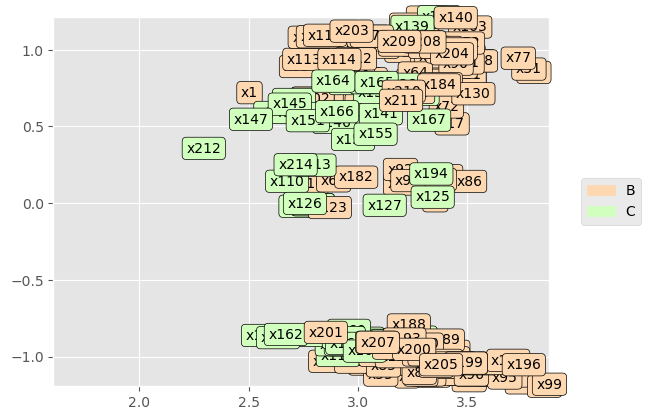

In [243]:
classification_dfx = electre_tri_b(arr_dfx, W_dfx , Q_dfx, P_dfx, V_dfx , B_dfx, cut_level=[0.75], verbose = False, rule = 'oc', graph = True)




In [224]:
# Filter the columns that have only two unique break values
two_breaks_columns = {k: v for k, v in breaks_dict_dfx.items() if len(set(v)) == 2}

print(two_breaks_columns)




{}


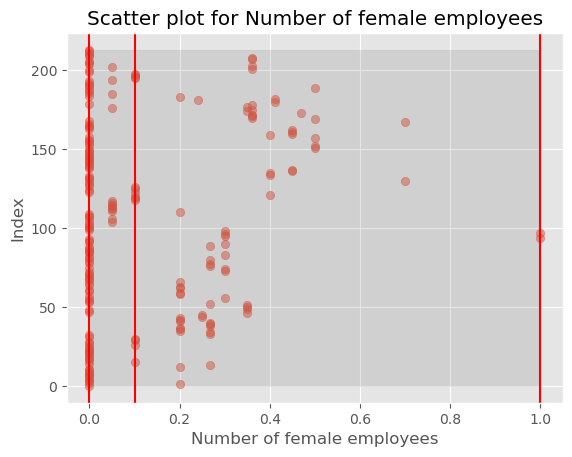

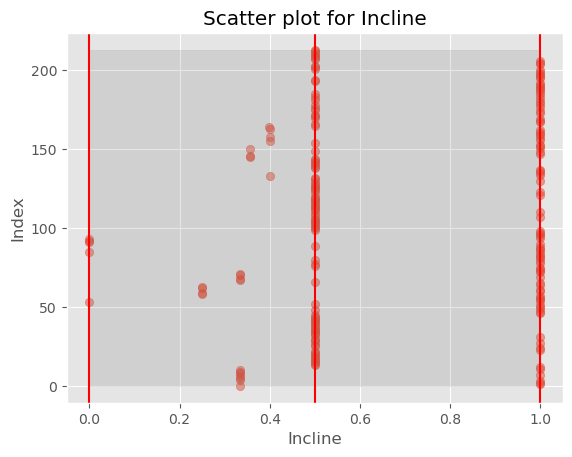

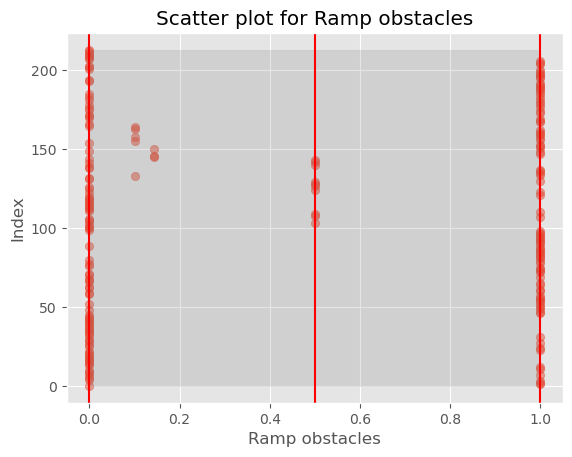

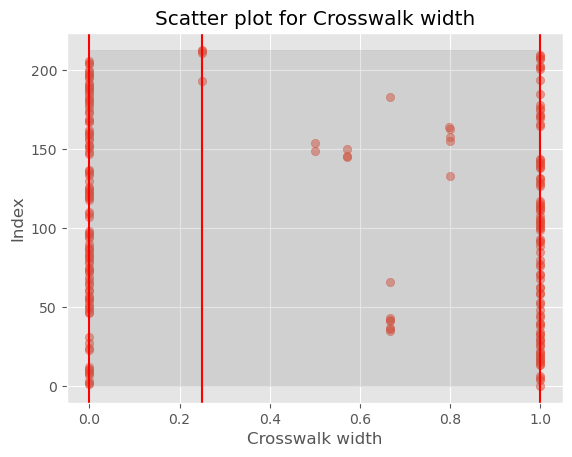

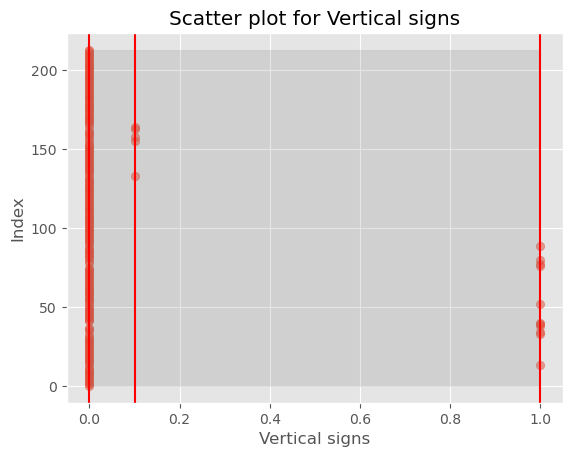

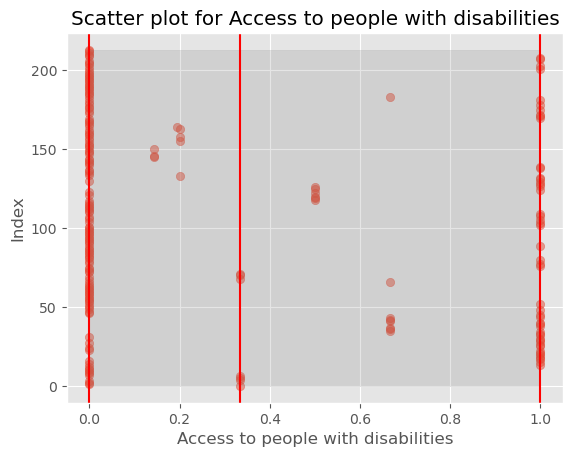

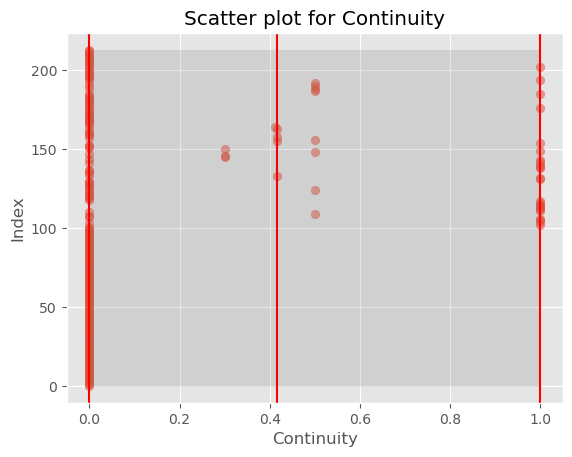

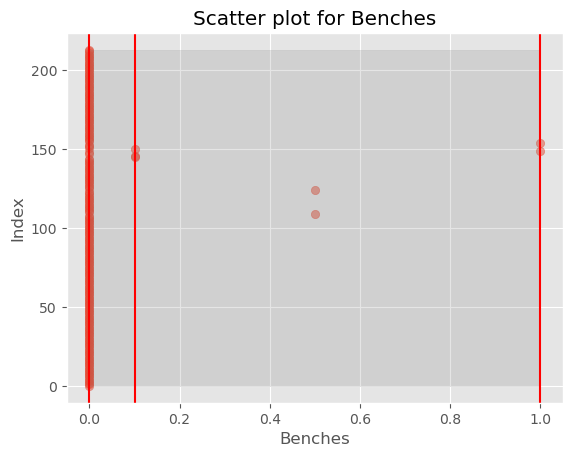

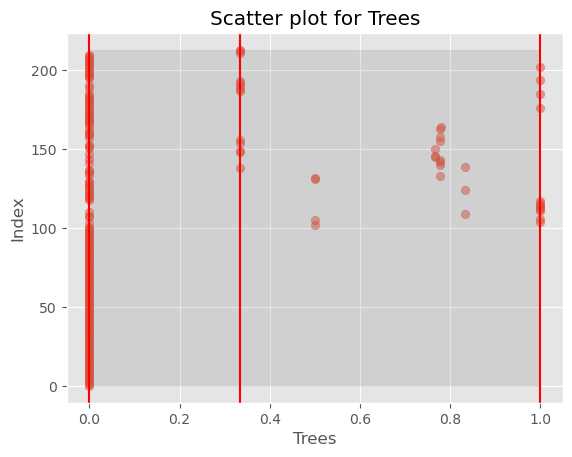

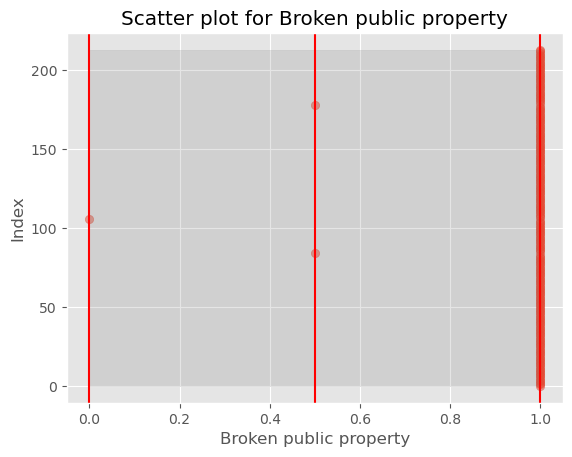

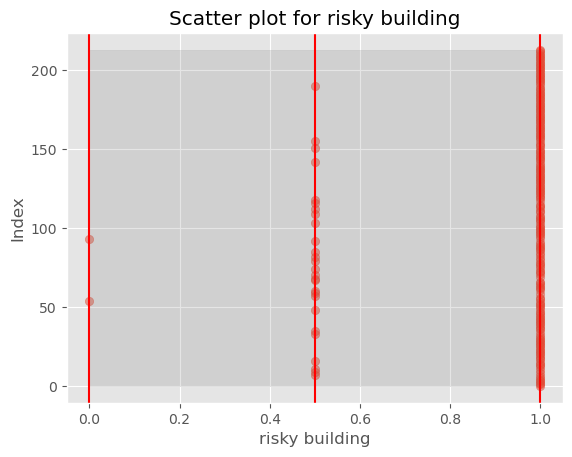

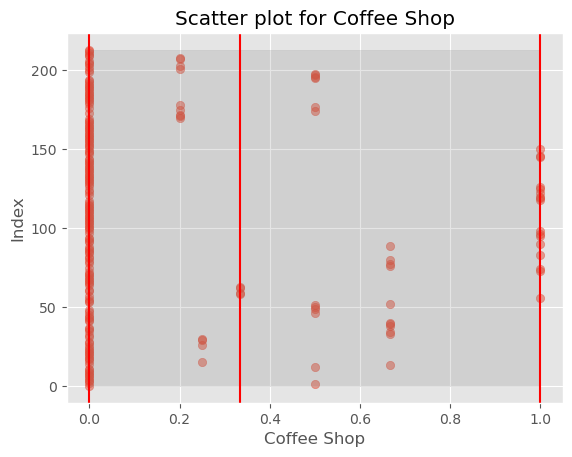

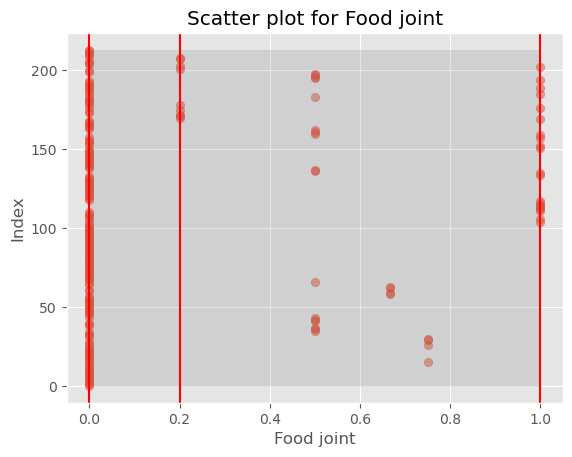

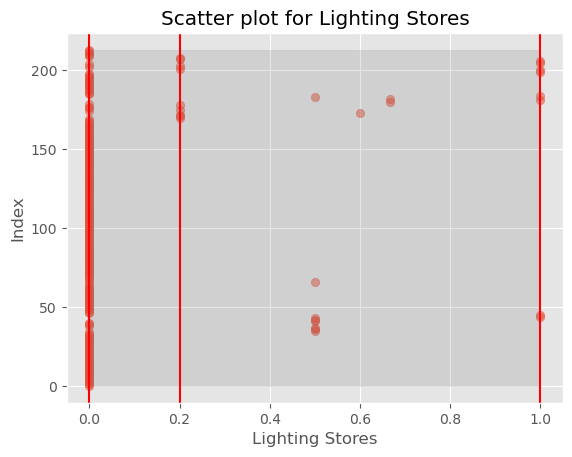

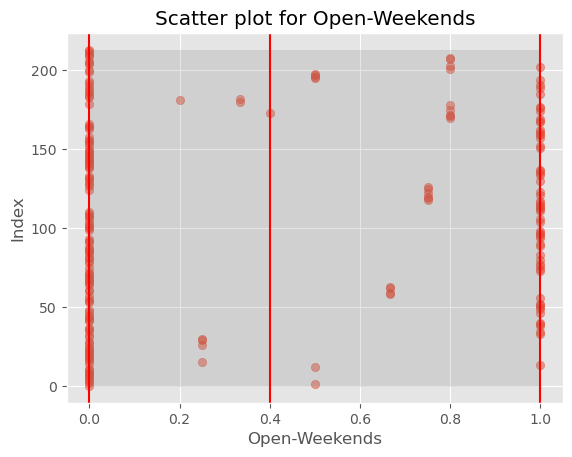

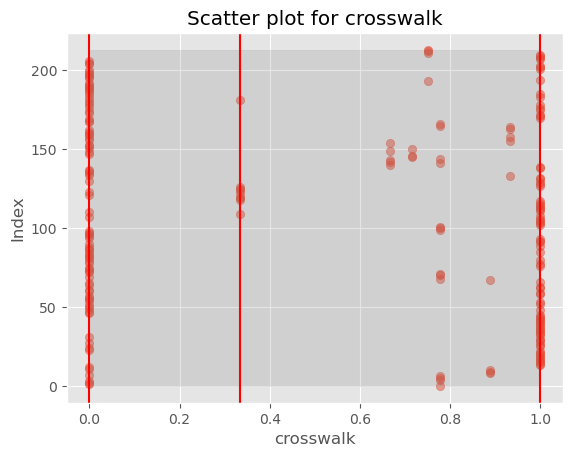

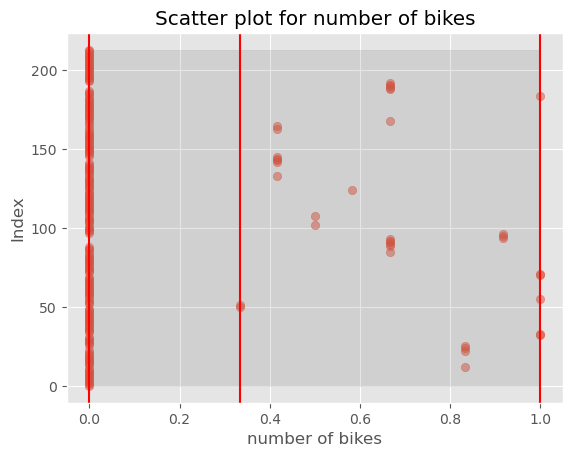

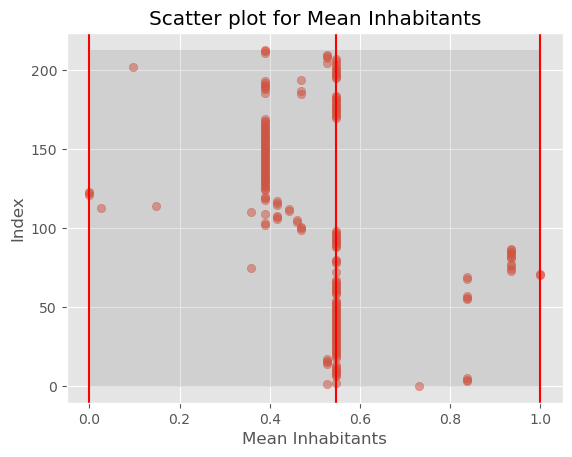

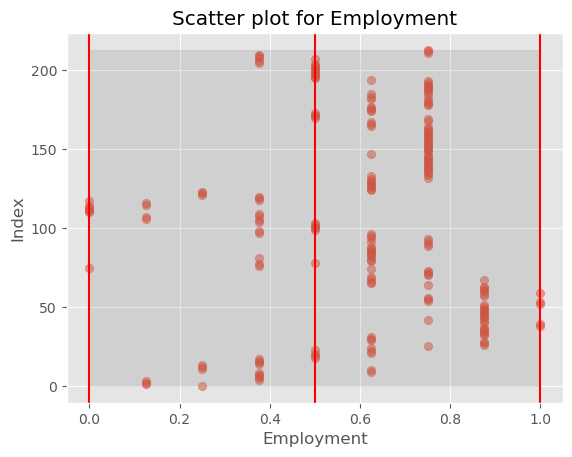

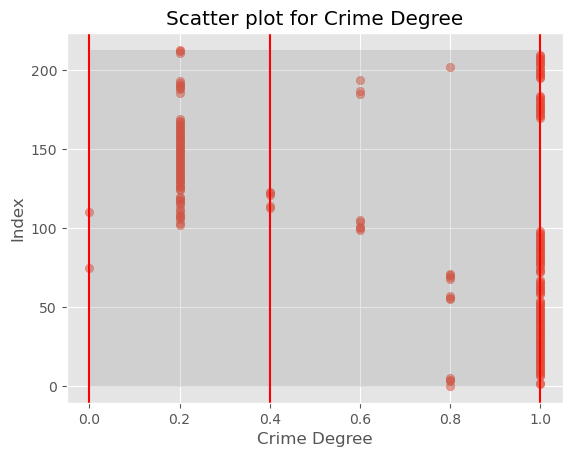

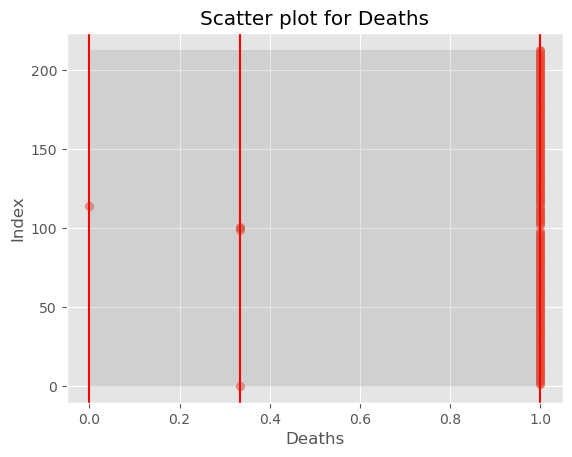

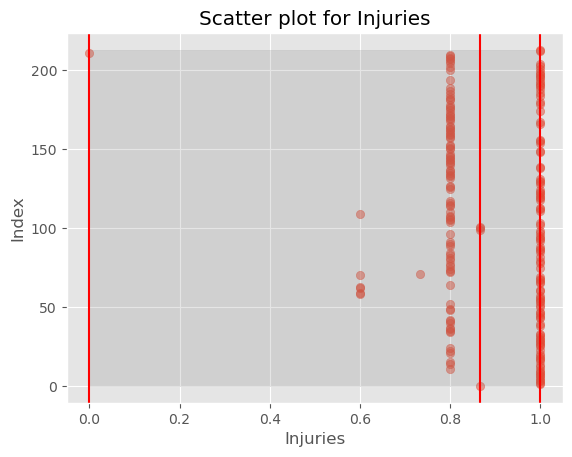

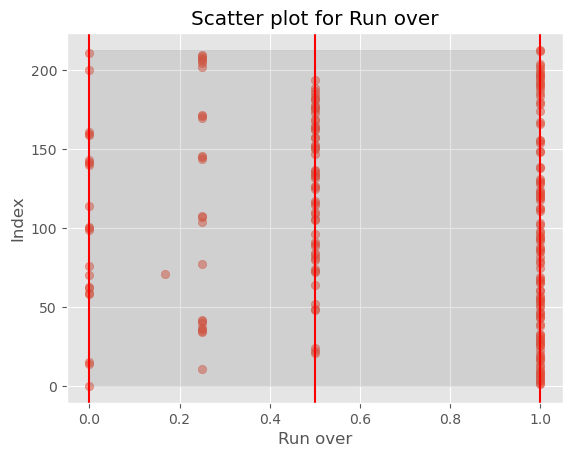

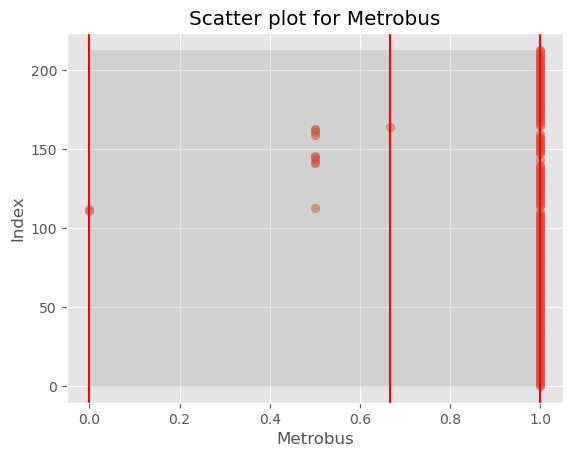

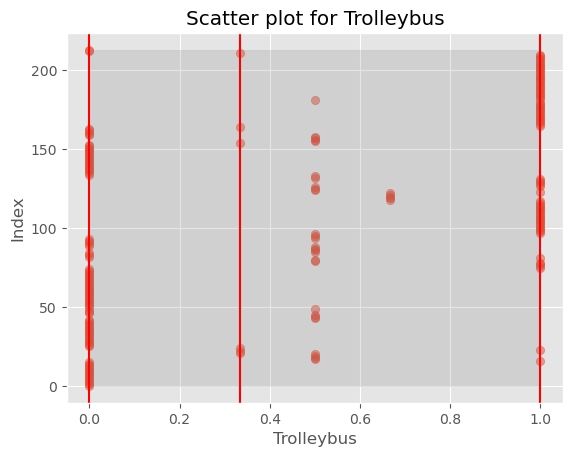

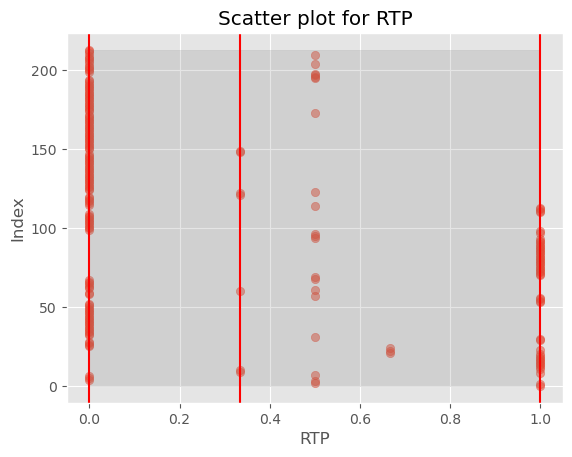

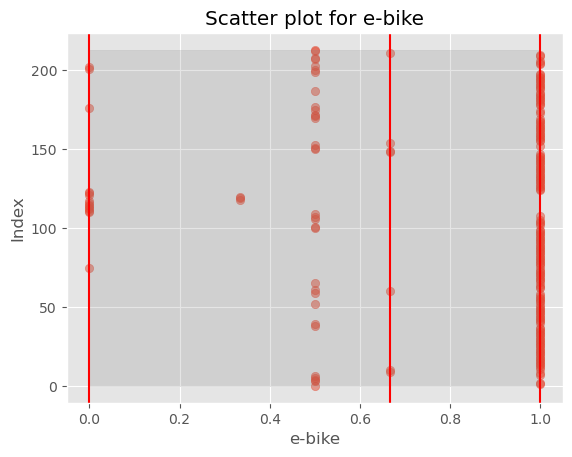

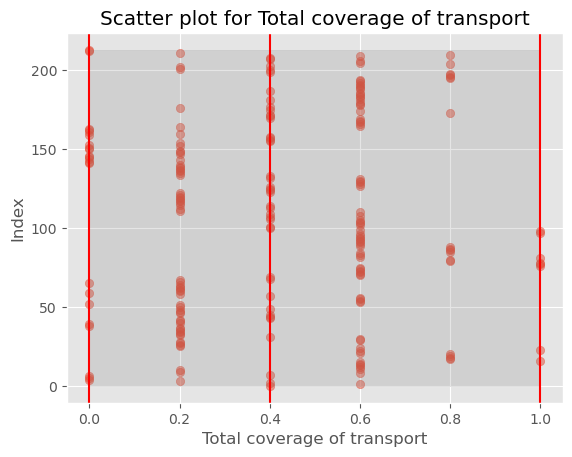

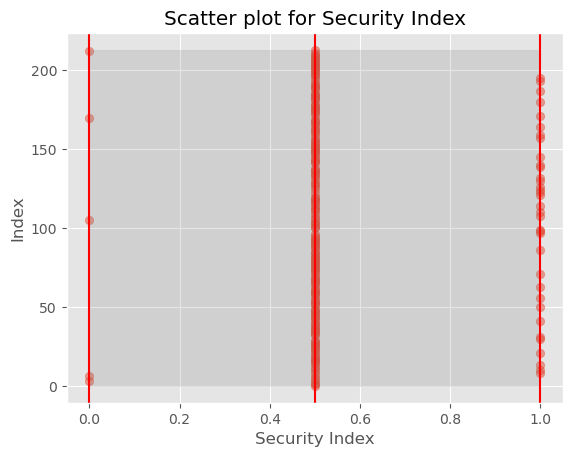

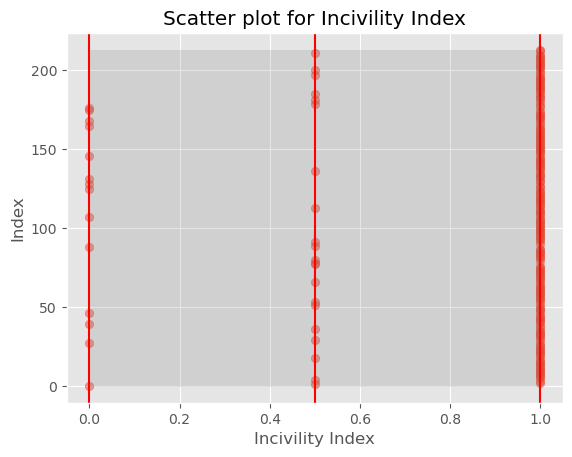

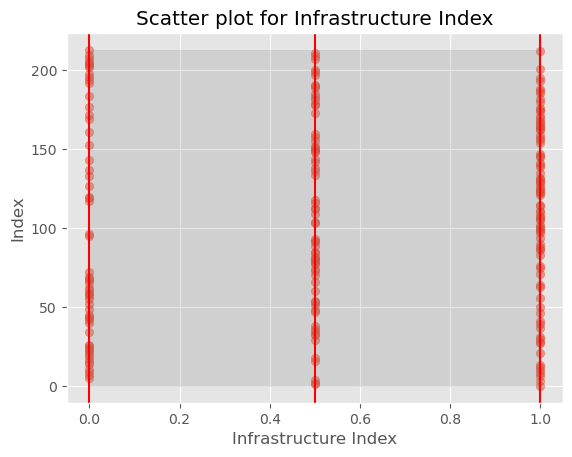

In [225]:
import numpy as np
import matplotlib.pyplot as plt

for column, breaks in breaks_dict_dfx.items():
    plt.scatter(dfx[column], dfx.index, alpha=0.5)

    sorted_breaks = sorted(breaks)
    for i in range(len(sorted_breaks) - 1):
        plt.fill_betweenx(dfx.index, sorted_breaks[i], sorted_breaks[i+1], color='gray', alpha=0.2)

    # Add vertical lines for the break points
    for break_point in breaks:
        plt.axvline(x=break_point, color='r')
    
    # Add title and labels
    plt.title(f'Scatter plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Index')
    
    
    plt.show()



In [238]:
# With no parameters:

W_n= [1] * 31
Q_n=[0.1] * 31
P_n=[0.1] * 31
V_n=[1] * 31
